In [2]:
import os
import re
import sys
import gc
import shutil
import unicodedata

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
from wordcloud import WordCloud

from bs4 import BeautifulSoup

#from konlpy.tag import Mecab 제대로 동작 안 함
from eunjeon import Mecab  # konlpy 대신  eunjeon 패키지 사용

# pands option
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# numpy option :  array출력 시 생략 하지 않고 출력
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# 주피터 노트북 메모리 늘리기
# 주피터 노트북 -> New -> terminal 열고 아래 command 입력
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

# C:\Users\iamsu\.jupyter\jupyter_notebook_config.py
# c.NotebookApp.iopub_data_rate_limit = 1.0e10 comment out
# restart 

import warnings
warnings.filterwarnings('ignore')

# 파일 핸들링

In [3]:
def get_dataframe(dirpath,filename):
    """
    csv 파일을 읽어서 DataFrame을 반환하는 함수
    """
    df = pd.read_csv(dirpath+filename)
    df = df.drop(['Unnamed: 0'], axis = 1)
    return df

def get_filename(filepath):
    """
    csv 파일의 확장자를 제거한 파일 이름만 반환하는 함수
    """
    return filepath.split('.')[0]

def get_review_list(df):
    """
    df['Review'] 열을 문장단위의 리스트로 저장하여 반환하는 함수
    """
    return df['Review'].values

def write_text_file_as_list(dirpath, filename, review_list):
    """
    List 의 각 요소를 text file 에 한줄씩 쓰기
    """
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    filepath = filename + '_list.txt'
    f = open(dirpath + filepath, 'w')
    f.write('\n'.join(review_list))
    f.close()
    
def write_text_file_as_str(dirpath, filename, data):
    """
    text file 에 string 형태로 쓰기
    """
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    filepath = filename + '_list.txt'
    f = open(dirpath + filepath, 'w')
    f.write(data)
    f.close()    
    
def read_text_file_as_list(dirpath, filename):
    """
    List 의 각 요소를 한줄씩 읽기
    """  
    filepath = filename + '_list.txt'
    with open(dirpath + filepath, 'r') as f:
        readList = f.readlines()
    return readList
  
def read_text_file_as_str(dirpath, filename):
    """
    하나의 string으로 읽기
    """      
    filepath = filename + '_list.txt'
    with open(dirpath + filepath, 'r') as f:
        review_str = f.read()# f.read().replace('\n', ' ')
    return review_str

In [4]:
def get_review(RAW_DATA_DIR, DATA_DIR, filepath):
    """
    csv 을 읽어서 \n 개행문자를 유지하여 라인을 유지하여 string으로 반환하는 함수
    """
    
    # 1. 데이터 읽어오기
    df = get_dataframe(RAW_DATA_DIR, filepath)
    df.head()
    
    # 2. 파일명 얻어오기
    filename = get_filename(filepath)
    
    # 3. df['Review'] 열을 문장단위의 리스트로 저장하기
    review_list = get_review_list(df)
    
    # 4. 댓글을 리스트 형태로 txt파일에 쓰기
    # List 의 각 요소를 text file 에 한줄씩 쓰기
    write_text_file_as_list(DATA_DIR, get_filename(filepath), review_list) 
    
    # 5. txt파일을 리스트 형태로 읽어오기
    review_list = read_text_file_as_list(DATA_DIR, get_filename(filepath))
    
    # 6. txt파일을 String 형태로 읽어오기(\n)
    review_str = read_text_file_as_str(DATA_DIR, get_filename(filepath))
    
    return review_str

In [5]:
def clean_review(review_str):
    """
    행단위 한국어 전처리하여 정제된 데이터를 반환하는 함수
        - 라인 단위 for루프 처리는 성능 저하
        - '\n'유지한채로 for루프 없이 성능향상    
    """    
    document = review_str
    
    # 1. 크롤링한 데이터이므로 HTML TAG 제거
    doc = BeautifulSoup(document, 'html.parser').get_text()

    # 2. 한글만 추출( 구둣점, 이모티콘 자동 제거됨) \n유지
    doc = re.sub("[^ ㄱ-ㅣㅣ가-힣\n]+", '', doc)

    # 3. ㄹㅇㅜㅜ 처럼 모음이나 자음만으로 이루어진 글자 제거
    doc = re.sub('[ㄱ-ㅣ]+','',doc)

    #4. 구두점 삭제
    # 구두점 문자로 이루어진 딕셔너리를 생성
    punctuation = dict.fromkeys( i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))
    doc = doc.translate(punctuation)

    # 5. (흐어어어어어어어어어어어어어어어어어어) 반복어 삭제
    doc = re.sub('(([[ㄱ-ㅣ가-힣0-9\n])\\2{1,})','', doc)
    
    return doc

In [6]:
def preprocess():
    """
    댓글 리뷰 파일을 읽어와서 정제하여 저장하는 함수
    """
    RAW_DATA_DIR = '../크롤링/data/kr/'
    DATA_DIR = './data/'  # /자연어 처리/data
    filepath = "kr_전지적 독자 시점_episode_total.csv"  
    
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)   
    else:
        shutil.rmtree(DATA_DIR)
    
    # 데이터 읽어오기
    review_doc = get_review(RAW_DATA_DIR, DATA_DIR, filepath)
    
    # 데이터 정제하기
    cleaned_doc = clean_review(review_doc)
    
    # 정제된 데이터 저장하기
    write_text_file_as_str(DATA_DIR, get_filename(filepath) + '_cleaned', cleaned_doc)
    
    # 저장된 파일 읽어보기
    doc = read_text_file_as_str(DATA_DIR, get_filename(filepath) + '_cleaned')
    
    print("Preprocess Done.")
    return doc

In [7]:
def generate_word_tokens(cleaned_doc):
    """
    nlp activate 환경에서 Mecab() 을 이용하여 토큰 생성
    """
    # %%time
    # %timeit으로 jupyter notebook에서 Cell 단위 코드 수행 시간 확인하기

    mecab = Mecab('C:/mecab/mecab-ko-dic')
    word_tokens = mecab.morphs(cleaned_doc)
    
    print("word_tokens generated.")
    return word_tokens

def make_stop_words():
    """
    한국어 불용어 stop_words 리스트를 생성하는 함수
    """
    f = open("./불용어 사전 파일/stopwords_ko.txt", 'r')
    lines = f.readlines()
    f.close()
    
    stop_words = []
    for line in lines:
        line = line.replace('\n', '')
        stop_words.append(line)
        
    print("stop_words made")
    return stop_words

def remove_stop_words(word_tokens, stop_words):
    """
    한국어 불용어를 제거하는 함수
    """
    vocab={}
    sentences = []
    result = []

    for word in word_tokens: 
        if word not in stop_words:
            if len(word) > 1: # 단어 길이가 1인 단어 제거
                result.append(word)
                if word not in vocab:
                    vocab[word] = 0 
                vocab[word] += 1
    sentences.append(result)
    
    print("stop_words removed")
    return vocab

In [8]:
def get_keyword_frequency(vocab):
    """
    (keyword, frequency)를 구하는 함수
    """
    vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)
    keyword_frequency = np.array(vocab_sorted)    
    keyword = [word[0] for word in vocab_sorted]
    frequency = [word[1] for word in vocab_sorted]
    return keyword, frequency, keyword_frequency

def save_keyword(keyword, keyword_frequency):
    """
    (keyword, frequency)를 저장하는 함수
    """
    DATA_DIR = './data/'  # /자연어 처리/data
    filepath = "kr_전지적 독자 시점_episode_total.csv"  
    
    filename = get_filename(filepath)
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
        
    filepath = filename + '_keyword_kr.txt'
    f = open(DATA_DIR + filepath, 'w')
    f.write(','.join(keyword))
    f.close()
    
    filepath = filename + '_keyword_frequency_kr.txt'
    f = open(DATA_DIR + filepath, 'w')
    f.write(np.array2string(keyword_frequency))
    f.close()
    
def get_top10(keyword, frequency):
    """
    시각화를 위해서 (keyword, frequency)를 데이터 프레임으로 생성하고
    top10 데이터를 리턴하는 함수
    """
    df = pd.DataFrame(zip(keyword,frequency))
    df.columns = ['keyword','frequency']
    df = df.set_index(keys= 'keyword', drop=True)
    top10 = df[:10].sort_values(by='frequency',ascending=True)
    return top10
    
def make_wordcloud(dirpath, vocab):
    """
    워드클라우드 시각화
    """
    wc = WordCloud(font_path='malgun', background_color='white',     width = 800, height = 800, scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(vocab)
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wc.to_file(dirpath + "top10_워드클라우드_한글.png")
    
def make_barh_chart(dirpath, top10):
    """
    가로막대바 시각화
    """    
    top10.plot(kind='barh', color='cornflowerblue', width=0.5, figsize=(10,10),fontsize=20 )
    plt.style.use('ggplot')
    plt.title('중요 키워드 top10', fontsize=30 , loc ='center', pad=20)
    # plt.legend(loc='best')
    plt.xlabel('빈도수', size = 15)
    plt.ylabel('키워드', size = 15)
    plt.savefig(dirpath + 'top10_가로바차트_한글.png', dpi = 100)
    plt.show()
    
def make_pie1_chart(dirpath, top10):
    """
    파이차트 시각화(데이터프레임에서 제공하는 plot()이용)
    """        
    top10_pie = top10['frequency']
    top10_pie.plot(kind='pie', figsize=(10,10), autopct='%1.1f%%', startangle=0, counterclock=False, shadow=True, fontsize=20) # , colors=['chocolate', 'bisque','cadetblue'] colors=['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
    plt.title('중요 키워드 top10', fontsize=30 , loc ='left', pad=20)
    plt.legend(loc=10)
    plt.savefig(dirpath + 'top10_파이차트1_한글.png', dpi = 100)
    plt.show()
    
def make_pie2_chart(dirpath, top10):
    """
    파이차트 시각화(plt에서 제공하는 pie()이용)
    """       
    ratio = top10['frequency'].values
    labels = top10.index.to_list()
    labels

    # information of groups
    group_names = top10.index.to_list()
    group_sizes = top10['frequency'].values
    group_colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
    group_explodes = (0.1, 0, 0) # explode 1st slice

    # plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False,  shadow=True, colors=colors)
    # plt.show()

    # # Pie chart
    plt.figure(figsize = (10,10))
    plt.pie(group_sizes, 
    #         explode=group_explodes, 
            labels=group_names, 
            colors=group_colors, 
            autopct='%1.2f%%', # second decimal place
            shadow=True, 
            startangle=90,
            textprops={'fontsize': 20}) # text font size
    plt.axis('equal') #  equal length of X and Y axis
    plt.title('중요 키워드 top10', fontsize=30 , loc ='left', pad=20)
    plt.legend(loc=10)
    plt.savefig(dirpath + 'top10_파이차트2_한글.png', dpi = 100)
    plt.show()    

Preprocess Done.
word_tokens generated.
stop_words made
stop_words removed
Document cleaned.
Top10 keywords saved.


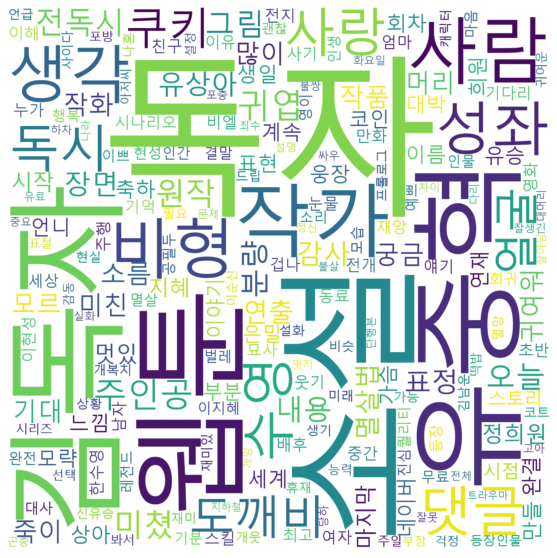

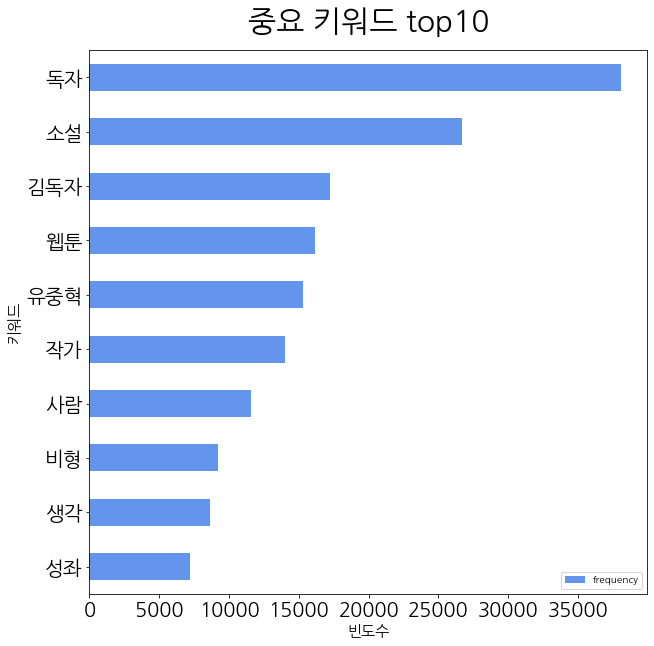

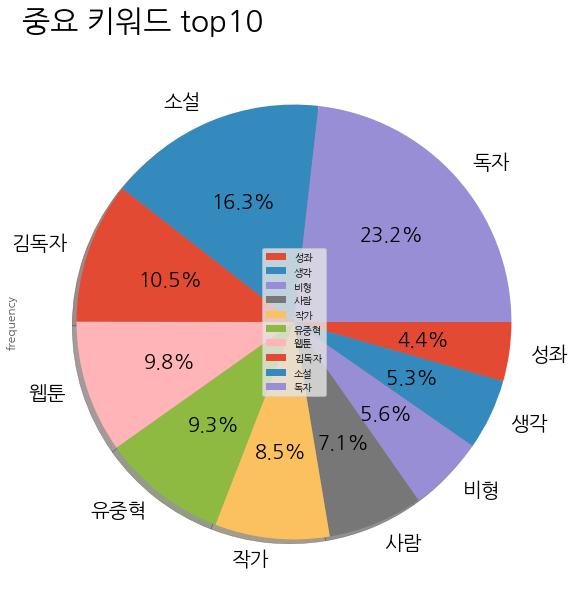

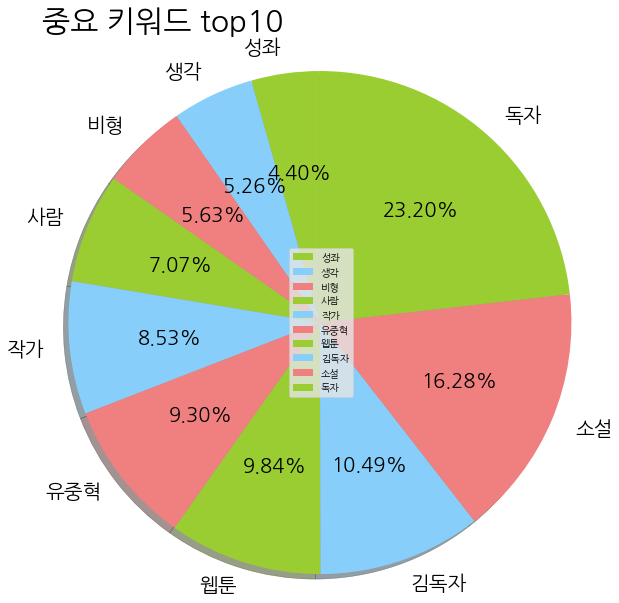

Top10 keywords visualized.


In [9]:
if __name__=="__main__":
    # 데이터 정제
    cleaned_doc = preprocess()
    word_tokens = generate_word_tokens(cleaned_doc)
    stop_words = make_stop_words()
    vocab = remove_stop_words(word_tokens, stop_words)
    print("Document cleaned.")
    
    # 빈도 분석
    keyword, frequency, keyword_frequency = get_keyword_frequency(vocab)
    save_keyword(keyword, keyword_frequency)
    top10 = get_top10(keyword, frequency)
    print("Top10 keywords saved.")
    
    # 시각화
    DATA_DIR = './data/'  # /자연어 처리/data
    make_wordcloud(DATA_DIR, vocab)
    make_barh_chart(DATA_DIR, top10)
    make_pie1_chart(DATA_DIR, top10)
    make_pie2_chart(DATA_DIR, top10)
    print("Top10 keywords visualized.")